In [2]:
import os
import sys
import numpy as np
import polars as pl

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(notebook_dir)



project_path = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding"
model = "FOXA1"
sample = "22Rv1"
jaspar_file = f"/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/motifs/{model}.jaspar"  # Update this path
ground_truth_file = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/transcription_factors/FOXA1/merged/22RV1_FOXA1_merged.bed"

df = pl.read_parquet("/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/processed_results/FOXA1-NoFlip_22Rv1_processed.parquet", 
                    columns=["chr_name", "start", "end", "cell_line", "targets", "predicted", "weights", "probabilities", "attributions"],
                    # low_memory=True,                        # Reduce memory usage
                    parallel="columns",                     # Enable parallel reading
                    use_statistics=True,                    # Use parquet statistics
                    memory_map=True).lazy()                         # Use memory mapping
df = df.rename({"chr_name": "chr"})
df


In [3]:
import os
import tempfile
import polars as pl
from src.utils.generate_training_peaks import run_bedtools_command

def intersect_bed_files(main_df: pl.LazyFrame, intersect_df: pl.DataFrame, region_type: str = None) -> pl.LazyFrame:
    """
    Intersect two BED files using bedtools and return the original DataFrame with overlap flags.
    Args:
    main_df: Primary Polars DataFrame with BED data
    intersect_df: Secondary Polars DataFrame to intersect with
    region_type: Optional region type label to add to results
    Returns:
    Original DataFrame with additional column indicating overlaps
    """
    # Get column names from schema
    main_cols = main_df.schema.keys()
    
    with tempfile.NamedTemporaryFile(delete=False, mode='w') as main_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as intersect_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as result_file:
        main_path = main_file.name
        intersect_path = intersect_file.name
        result_path = result_file.name
        
        # Write DataFrames to temporary files - collect LazyFrame first
        main_df.collect().write_csv(main_path, separator="\t", include_header=False)
        intersect_df.write_csv(intersect_path, separator="\t", include_header=False)
        
        # Run bedtools intersect with -c flag to count overlaps
        command = f"bedtools intersect -a {main_path} -b {intersect_path} -c > {result_path}"
        run_bedtools_command(command)
        
        # Read results back into Polars DataFrame
        result_df = pl.read_csv(
            result_path,
            separator="\t",
            has_header=False,
            new_columns=[*main_cols, "overlap_count"]
        ).lazy()
        
        # Clean up temporary files
        os.remove(main_path)
        os.remove(intersect_path)
        os.remove(result_path)
        
        # Add boolean overlap column
        return result_df.with_columns(
            pl.col("overlap_count").gt(0).alias("overlaps_ground_truth")
        ).drop("overlap_count")

HIGH_COUNT_QUANTILE = 0.75
MAX_COUNT_THRESHOLD = 30
MID_COUNT_THRESHOLD = 10

def threshold_peaks(df):
    """
    Filter peaks based on count thresholds.
    Works with both DataFrame and LazyFrame.
    """
    # Handle scalar operations safely
    def get_scalar(expr):
        if isinstance(df, pl.LazyFrame):
            return expr.collect().item()
        return expr.item()
    
    max_count = get_scalar(df.select(pl.col("count").max()))
    
    if max_count <= 2:
        return df
    elif max_count > MAX_COUNT_THRESHOLD:
        threshold = get_scalar(df.select(pl.col("count").quantile(HIGH_COUNT_QUANTILE)))
        return df.filter(pl.col("count") > threshold)
    elif max_count > MID_COUNT_THRESHOLD:
        threshold = get_scalar(df.select(pl.col("count").median()))
        return df.filter(pl.col("count") > threshold)
    
    return df

# Usage example:
df_ground_truth = pl.read_csv(ground_truth_file,
                             separator="\t",
                             has_header=False,
                             new_columns=["chr", "start", "end", "count"],
                             columns=[0,1,2,3])

df_ground_truth_filtered = threshold_peaks(df_ground_truth)

# Use select() instead of subscripting
intersected_df = intersect_bed_files(df.select(["chr", "start", "end"]), df_ground_truth_filtered)

# add overlaps ground truth to df from intersected_df
ground_truth_df = df.join(intersected_df, on=["chr", "start", "end"], how="left")

# add overlaps_ground_truth to df under targets, 1 if overlaps_ground_truth is true, 0 otherwise
ground_truth_df = ground_truth_df.with_columns(
    pl.when(pl.col("overlaps_ground_truth")).then(1).otherwise(0).alias("targets")
)

/tmp/ipykernel_158217/1164732145.py:17: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  main_cols = main_df.schema.keys()


In [4]:
# Step 1: Keep the filtering lazy until collection
df_positive = ground_truth_df.filter(pl.col("targets") == 1).collect()
df_negative_all = ground_truth_df.filter(pl.col("targets") == 0).collect()

# Step 2: Get the count of positive samples
pos_count = len(df_positive)

# Step 3: Sample from the materialized negative DataFrame
df_negative = df_negative_all.sample(n=min(pos_count, len(df_negative_all)), seed=42)

# Step 4: Concatenate the two DataFrames
df_balanced = pl.concat([df_positive, df_negative])

df_balanced

chr,start,end,cell_line,targets,predicted,weights,probabilities,attributions,overlaps_ground_truth
str,i64,i64,str,i32,f64,f64,f64,list[list[f64]],bool
"""chr3""",131331117,131332340,"""22Rv1""",1,1.0,-1.0,0.999869,"[[0.0, 0.0, … 0.0127], [0.0, 0.036142, … 0.013699], … [0.0, 0.0, … 0.024706]]",true
"""chr3""",194870593,194872665,"""22Rv1""",1,1.0,-1.0,0.999569,"[[0.0, 0.0, … 0.061992], [0.079921, 0.0, … 0.064706], … [0.0, 0.0, … -0.005459]]",true
"""chr9""",127954906,127956174,"""22Rv1""",1,1.0,-1.0,0.999902,"[[0.0, 0.0, … -0.025018], [-0.011296, 0.00434, … -0.040145], … [0.0, 0.0, … -0.011693]]",true
"""chr2""",224971207,224971562,"""22Rv1""",1,1.0,-1.0,0.996018,"[[0.0, 0.0, … 0.001533], [0.0, 0.0, … 0.004405], … [0.0, 0.0, … 0.005174]]",true
"""chr1""",243849057,243851465,"""22Rv1""",1,1.0,-1.0,0.997744,"[[0.0, 0.0, … 0.032383], [0.0, 0.0, … 0.032349], … [0.0, 0.0, … -0.072369]]",true
…,…,…,…,…,…,…,…,…,…
"""chr12""",67068122,67070343,"""22Rv1""",0,0.0,-1.0,0.133742,"[[0.0, 0.0, … -0.001081], [0.016729, 0.0, … -0.00186], … [0.0, 0.0, … -0.063814]]",false
"""chr7""",123580292,123581582,"""22Rv1""",0,0.0,-1.0,0.448366,"[[0.0, 0.0, … 0.003561], [0.0, 0.0, … 0.003485], … [0.0, 0.0, … -0.008077]]",false
"""chr3""",128893798,128894166,"""22Rv1""",0,0.0,-1.0,0.000564,"[[0.0, 0.0, … -0.001435], [0.0, 0.0, … -0.002461], … [0.0, 0.0, … 0.00174]]",false


In [8]:
import os
import sys
import polars as pl
import pysam
from pathlib import Path
import numpy as np
from typing import Tuple, List, Dict, Optional
import gc
try:
    from tqdm import tqdm
except ImportError:
    # Fallback if tqdm is not available
    def tqdm(iterable, desc="", leave=True, total=None):
        return iterable


def process_pileups(pileup_dir: Path, chr_name: str, start: int, end: int) -> pl.DataFrame:
    """Process pileup files for a given genomic region with 4096bp context."""
    context_length = 4_096
    interval_length = end - start
    extra_seq = context_length - interval_length
    extra_left_seq = extra_seq // 2
    extra_right_seq = extra_seq - extra_left_seq
    start -= extra_left_seq
    end += extra_right_seq
    
    # Get the pileup file for the given chromosome
    pileup_file = pileup_dir / f"{chr_name}.pileup.gz"
    assert pileup_file.exists(), f"pileup file for {pileup_file} does not exist"
    
    tabixfile = pysam.TabixFile(str(pileup_file))
    records = []
    
    try:
        for rec in tabixfile.fetch(chr_name, start, end):
            records.append(rec.split("\t"))
    finally:
        tabixfile.close()
    
    # Convert records to a DataFrame using Polars
    df = pl.DataFrame({
        "chr_name": [rec[0] for rec in records],
        "position": [int(rec[1]) for rec in records],
        "nucleotide": [rec[2] for rec in records],
        "count": [float(rec[3]) for rec in records],
    })
    
    return df


def create_position_to_count_mapping(pileup_df: pl.DataFrame) -> Dict[int, float]:
    """Create a mapping from genomic position to ATAC count."""
    # Handle both lazy and eager frames efficiently
    if hasattr(pileup_df, 'collect'):
        df_collected = pileup_df.collect()
    else:
        df_collected = pileup_df
        
    positions = df_collected.get_column("position").to_list()
    counts = df_collected.get_column("count").to_list()
    return dict(zip(positions, counts))


def create_atac_pileup_array(position_count_map: Dict[int, float], 
                            start_pos: int, 
                            length: int = 4096) -> np.ndarray:
    """Create ATAC pileup array for a genomic region."""
    atac_array = np.zeros(length, dtype=np.float32)  # Use float32 to save memory
    
    for i in range(length):
        pos = start_pos + i
        if pos in position_count_map:
            atac_array[i] = position_count_map[pos]
    
    return atac_array


def safe_collect_series(df: pl.DataFrame, column: str) -> pl.Series:
    """Safely collect a series from either LazyFrame or DataFrame."""
    try:
        if hasattr(df, 'collect'):
            return df.select(column).collect().get_column(column)
        else:
            return df.get_column(column)
    except Exception as e:
        print(f"Error collecting column '{column}': {e}")
        raise


def reshape_attributions_fast(df: pl.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Memory-efficient reshape attribution data using vectorized operations.
    
    Returns:
        attrs_list: Attribution scores for ACGT (shape: n_samples, 4, 4096)
        atac_attribution_list: ATAC attribution scores (shape: n_samples, 4096)
    """
    print("Reshaping attribution data...")
    
    try:
        # Get attributions series safely
        attributions_series = safe_collect_series(df, "attributions")
        attributions_list = attributions_series.to_list()
        
        # Check if we have data
        if not attributions_list:
            raise ValueError("No attribution data found")
            
        # Convert to numpy array with memory-efficient dtype
        print(f"Converting {len(attributions_list)} attribution records to numpy array...")
        attributions = np.array(attributions_list, dtype=np.float32)
        
        # Clear the list to free memory
        del attributions_list
        gc.collect()
        
        print(f"Attribution array shape: {attributions.shape}")
        
        # Vectorized reshape - much faster than loops
        reshaped = attributions.reshape(-1, 4096, 5)
        
        # Split into ACGT and ATAC components
        attrs_list = reshaped[..., :4].transpose(0, 2, 1)  # Shape: (n_samples, 4, 4096)
        atac_attribution_list = reshaped[..., 4]  # Shape: (n_samples, 4096)
        
        # Clean up intermediate arrays
        del attributions, reshaped
        gc.collect()
            
        return attrs_list, atac_attribution_list
        
    except Exception as e:
        print(f"Error in reshape_attributions_fast: {e}")
        raise


def get_unique_chromosomes(df: pl.DataFrame) -> List[str]:
    """Extract unique chromosomes from the dataframe."""
    try:
        chr_series = safe_collect_series(df, "chr")
        return chr_series.unique().to_list()
    except Exception as e:
        print(f"Error getting unique chromosomes: {e}")
        return []


def open_chromosome_tabix_files(pileup_dir: Path, chromosomes: List[str]) -> Dict[str, pysam.TabixFile]:
    """Open tabix files for all chromosomes and return mapping."""
    chr_tabix_files = {}
    
    print(f"Opening tabix files for {len(chromosomes)} chromosomes...")
    for chr_name in tqdm(chromosomes, desc="Loading chromosome files", leave=False):
        pileup_file = pileup_dir / f"{chr_name}.pileup.gz"
        if pileup_file.exists():
            try:
                chr_tabix_files[chr_name] = pysam.TabixFile(str(pileup_file))
            except Exception as e:
                print(f"Warning: Could not open {pileup_file}: {e}")
    
    return chr_tabix_files


def process_single_region(row: Dict, chr_tabix_files: Dict[str, pysam.TabixFile], context_length: int = 4096) -> np.ndarray:
    """Process a single genomic region and return ATAC array."""
    idx, chr_name, start, end = row['idx'], row['chr'], row['start'], row['end']
    
    # Calculate adjusted coordinates
    interval_length = end - start
    extra_seq = context_length - interval_length
    extra_left_seq = extra_seq // 2
    extra_right_seq = extra_seq - extra_left_seq
    adj_start = start - extra_left_seq
    adj_end = end + extra_right_seq
    
    # Initialize array with float32 to save memory
    atac_array = np.zeros(context_length, dtype=np.float32)
    
    # Get data if tabix file exists
    if chr_name in chr_tabix_files:
        tabixfile = chr_tabix_files[chr_name]
        
        # Collect all positions and counts at once
        positions = []
        counts = []
        
        try:
            for rec in tabixfile.fetch(chr_name, adj_start, adj_end):
                fields = rec.split("\t")
                positions.append(int(fields[1]))
                counts.append(float(fields[3]))
            
            # Vectorized assignment
            if positions:
                positions = np.array(positions)
                counts = np.array(counts, dtype=np.float32)
                
                # Calculate array indices
                array_indices = positions - adj_start
                
                # Filter valid indices
                valid_mask = (array_indices >= 0) & (array_indices < context_length)
                valid_indices = array_indices[valid_mask]
                valid_counts = counts[valid_mask]
                
                # Assign values
                atac_array[valid_indices] = valid_counts
                
        except Exception as e:
            print(f"Warning: Could not fetch data for {chr_name}:{adj_start}-{adj_end}: {e}")
    
    return atac_array


def close_tabix_files(chr_tabix_files: Dict[str, pysam.TabixFile]) -> None:
    """Safely close all tabix files."""
    print("Closing tabix files...")
    for chr_name, tabixfile in chr_tabix_files.items():
        try:
            tabixfile.close()
        except Exception as e:
            print(f"Warning: Error closing tabix file for {chr_name}: {e}")


def process_pileups_batch(pileup_dir: Path, regions_df: pl.DataFrame) -> Dict[int, np.ndarray]:
    """Process multiple pileup regions for a single cell line efficiently."""
    context_length = 4_096
    
    # Get unique chromosomes to minimize file operations
    chromosomes = get_unique_chromosomes(regions_df)
    if not chromosomes:
        print("Warning: No chromosomes found in regions data")
        return {}
    
    chr_tabix_files = open_chromosome_tabix_files(pileup_dir, chromosomes)
    
    if not chr_tabix_files:
        print("Warning: No tabix files could be opened")
        return {}
    
    # Process each region
    atac_arrays = {}
    
    try:
        # Convert to regular DataFrame if it's a LazyFrame - but do it efficiently
        if hasattr(regions_df, 'collect'):
            regions_data = regions_df.collect()
        else:
            regions_data = regions_df
        
        region_iterator = regions_data.iter_rows(named=True)
        total_regions = regions_data.height
        
        for row in tqdm(region_iterator, total=total_regions, desc="Processing regions", leave=False):
            atac_array = process_single_region(row, chr_tabix_files, context_length)
            atac_arrays[row['idx']] = atac_array
    
    finally:
        # Always close tabix files
        close_tabix_files(chr_tabix_files)
    
    return atac_arrays


def get_dataframe_length(df: pl.DataFrame) -> int:
    """Get the length of a DataFrame, handling both lazy and eager frames."""
    try:
        if hasattr(df, 'collect'):
            return df.select(pl.len()).collect().item()
        else:
            return len(df)
    except Exception as e:
        print(f"Error getting dataframe length: {e}")
        return 0


def group_by_cell_line(df_with_idx: pl.DataFrame) -> List[Tuple]:
    """Group dataframe by cell line, handling both lazy and eager frames."""
    try:
        if hasattr(df_with_idx, 'collect'):
            # For LazyFrames, collect only the grouping operation
            return list(df_with_idx.group_by("cell_line"))
        else:
            return list(df_with_idx.group_by("cell_line"))
    except Exception as e:
        print(f"Error grouping by cell line: {e}")
        return []


import dask
from dask.distributed import Client, progress
from dask_jobqueue import SGECluster

def process_region_data_dask(df: pl.DataFrame, base_pileup_dir: Optional[Path] = None,
                             worker_cores: int = 4,
                             worker_memory: str = "16GB",
                             num_workers: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Memory-efficient processing of both attribution and pileup data using Dask.
    """
    if base_pileup_dir is None:
        base_pileup_dir = Path("/data1/projects/human_cistrome/aligned_chip_data/merged_cell_lines/")

    df_length = get_dataframe_length(df)
    if df_length == 0:
        raise ValueError("DataFrame is empty")

    print(f"Processing {df_length} regions across cell lines using Dask...")

    # 1. Reshape attributions
    # This part still runs on the client machine where this script is launched.
    # If `df` is too large for this step, you might need to use Dask DataFrames
    # from the beginning, which would be a more significant refactor.
    print("Step 1: Reshaping attribution data on the client...")
    attrs_list, atac_attribution_list = reshape_attributions_fast(df)
    print("Attribution reshaping complete.")

    # Add row index for tracking, ensure it's done before distributing tasks
    # If df is lazy, collect what's needed for grouping or ensure Dask can handle lazy Polars frames.
    # For simplicity, let's assume df is eager or collected before this point if it was lazy.
    df_with_idx = df.with_row_index("idx")

    # Initialize the final result array (on the client)
    # Ensure this array can fit in the client's memory. If not, results need to be written
    # to disk from workers and combined later (e.g., using Dask Array to_zarr or similar).
    final_atac_pileup_list = np.zeros((df_length, 4096), dtype=np.float32)
    
    print("Step 2: Setting up Dask SGECluster...")
    # Configure Dask SGECluster
    # Adjust cores, memory, queue, project etc. based on your SGE setup and job needs
    cluster = SGECluster(
        cores=worker_cores,
        memory=worker_memory,
        # queue=sge_queue,
        # project=sge_project,
        # Add other SGE options like walltime, log_directory, etc.
        # e.g., job_extra_directives=["-l h_rt=02:00:00"],
        # log_directory='./dask_logs'
    )

    # Scale the cluster to the desired number of workers
    cluster.scale(n=num_workers)
    # Or use adaptive scaling: cluster.adapt(minimum_jobs=2, maximum_jobs=num_workers)

    client = Client(cluster)
    print(f"Dask client created. Dashboard link: {client.dashboard_link}")

    # Group by cell line for batch processing
    # The group_by_cell_line function should ideally yield data that's manageable per task.
    # Polars' group_by on an eager DataFrame yields (group_key, sub_dataframe).
    # This sub_dataframe will be sent to the Dask worker.
    cell_line_groups = group_by_cell_line(df_with_idx)

    if not cell_line_groups:
        print("Warning: No cell line groups found")
        client.close()
        cluster.close()
        return attrs_list, atac_attribution_list, final_atac_pileup_list

    print(f"Step 3: Submitting {len(cell_line_groups)} cell line processing tasks to Dask...")
    delayed_tasks = []

    for cell_line_key, group_df_for_cell_line in tqdm(cell_line_groups, desc="Preparing Dask tasks"):
        # Ensure cell_line_name is a string
        cell_line_name = cell_line_key[0] if isinstance(cell_line_key, tuple) else cell_line_key
        
        pileup_dir = base_pileup_dir / cell_line_name / "pileup_mod"

        # `group_df_for_cell_line` is the Polars DataFrame for the current cell line.
        # This DataFrame will be serialized and sent to a Dask worker.
        # Ensure it's not excessively large for a single worker's memory,
        # although it should be smaller than the full `df`.
        # The `process_pileups_batch` function is what will run on the worker.
        task = dask.delayed(process_pileups_batch)(pileup_dir, group_df_for_cell_line)
        delayed_tasks.append(task)
    
    # Compute all tasks
    if delayed_tasks:
        print("Step 4: Computing tasks on Dask workers...")
        results_list_of_dicts = dask.compute(*delayed_tasks)
        # Add progress bar for Dask computation
        # progress(results_list_of_dicts) # This would require results_list_of_dicts to be futures if using client.compute
        # For dask.compute, you typically get the results back directly after it blocks.

        print("Step 5: Consolidating results from Dask workers...")
        # `results_list_of_dicts` will be a tuple containing lists of dictionaries.
        # We take the first element as dask.compute returns a tuple of results.
        for atac_arrays_dict in tqdm(results_list_of_dicts[0], desc="Consolidating results"):
            if atac_arrays_dict: # It could be {} if pileup_dir didn't exist
                for idx, atac_array in atac_arrays_dict.items():
                    final_atac_pileup_list[idx] = atac_array
    else:
        print("No tasks to compute.")

    # Clean up Dask cluster
    print("Step 6: Closing Dask client and cluster...")
    client.close()
    cluster.close()
    print("Processing complete!")
    
    return attrs_list, atac_attribution_list, final_atac_pileup_list


attrs_list, atac_attribution_list, atac_pileup_list = process_region_data_dask(df)

AttributeError: module 'dask' has no attribute 'utils'

In [ ]:
# Import additional required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo
from tangermeme.seqlet import recursive_seqlets

# Get seqlets
def get_seqlets(attrs_list):
    attrs_array = np.stack(attrs_list, axis=0)
    seqlets = recursive_seqlets(attrs_array.sum(axis=1))
    
    nt_idx = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    
    # Add sequences to seqlets df
    sequences = []
    for i in range(len(seqlets)):
        sample = seqlets.iloc[i]
        start = int(sample['start'])
        end = int(sample['end'])
        sample_idx = int(sample['example_idx'])
        
        sample_attrs = attrs_array[sample_idx, :, start:end].T.squeeze()
        hits = np.argmax(sample_attrs, axis=1)
        seq = ''.join([nt_idx[i] for i in hits])
        sequences.append(seq)
    seqlets['sequence'] = sequences
    
    return seqlets

# Plot function (simplified version)
def plot_seqlet(seqlets, attrs_list, sample_rank=0, context_size=20):
    sample = seqlets.iloc[[sample_rank]]
    slice = int(sample['example_idx'].tolist()[0])
    sequence = sample['sequence'].tolist()[0]
    start = int(sample['start'].tolist()[0])
    end = int(sample['end'].tolist()[0])
    
    seqlen = end - start
    window_size = seqlen + (context_size * 2)
    
    X_attr = attrs_list[slice]
    X_attr = X_attr.astype(np.float64)
    
    TSS_pos = int(np.mean([start, end]))
    window = (TSS_pos - (window_size // 2), TSS_pos + (window_size // 2))
    
    plt.figure(figsize=(16, 9), dpi=300)
    ax = plt.subplot(111)
    plot_logo(
        X_attr,
        ax=ax,
        start=window[0],
        end=window[1]
    )
    
    plt.xlabel("Genomic Coordinate")
    plt.ylabel("Attributions")
    plt.title(f"DeepLIFT Attributions for sample: {slice} | {sequence}")
    plt.show()

KeyboardInterrupt: 

In [7]:
seqlets = get_seqlets(attrs_list)
filtered_seqlets = seqlets[seqlets["sequence"] == "AAAAA"]
filtered_seqlets

,example_idx,start,end,attribution,p-value,sequence
437,10923,1667,1672,-6.327283,0.000054,AAAAA
475,9170,2029,2034,-6.291553,0.000057,AAAAA
918,1263,1875,1880,15.642306,0.000105,AAAAA
953,13613,2302,2307,-5.367731,0.000109,AAAAA
2266,2791,1973,1978,-5.815860,0.000247,AAAAA
...,...,...,...,...,...,...
112409,8728,63,68,0.936256,0.009893,AAAAA
112418,10808,810,815,1.035007,0.009893,AAAAA
112420,1607,1897,1902,1.072662,0.009893,AAAAA
112424,8680,2250,2255,1.021970,0.009893,AAAAA


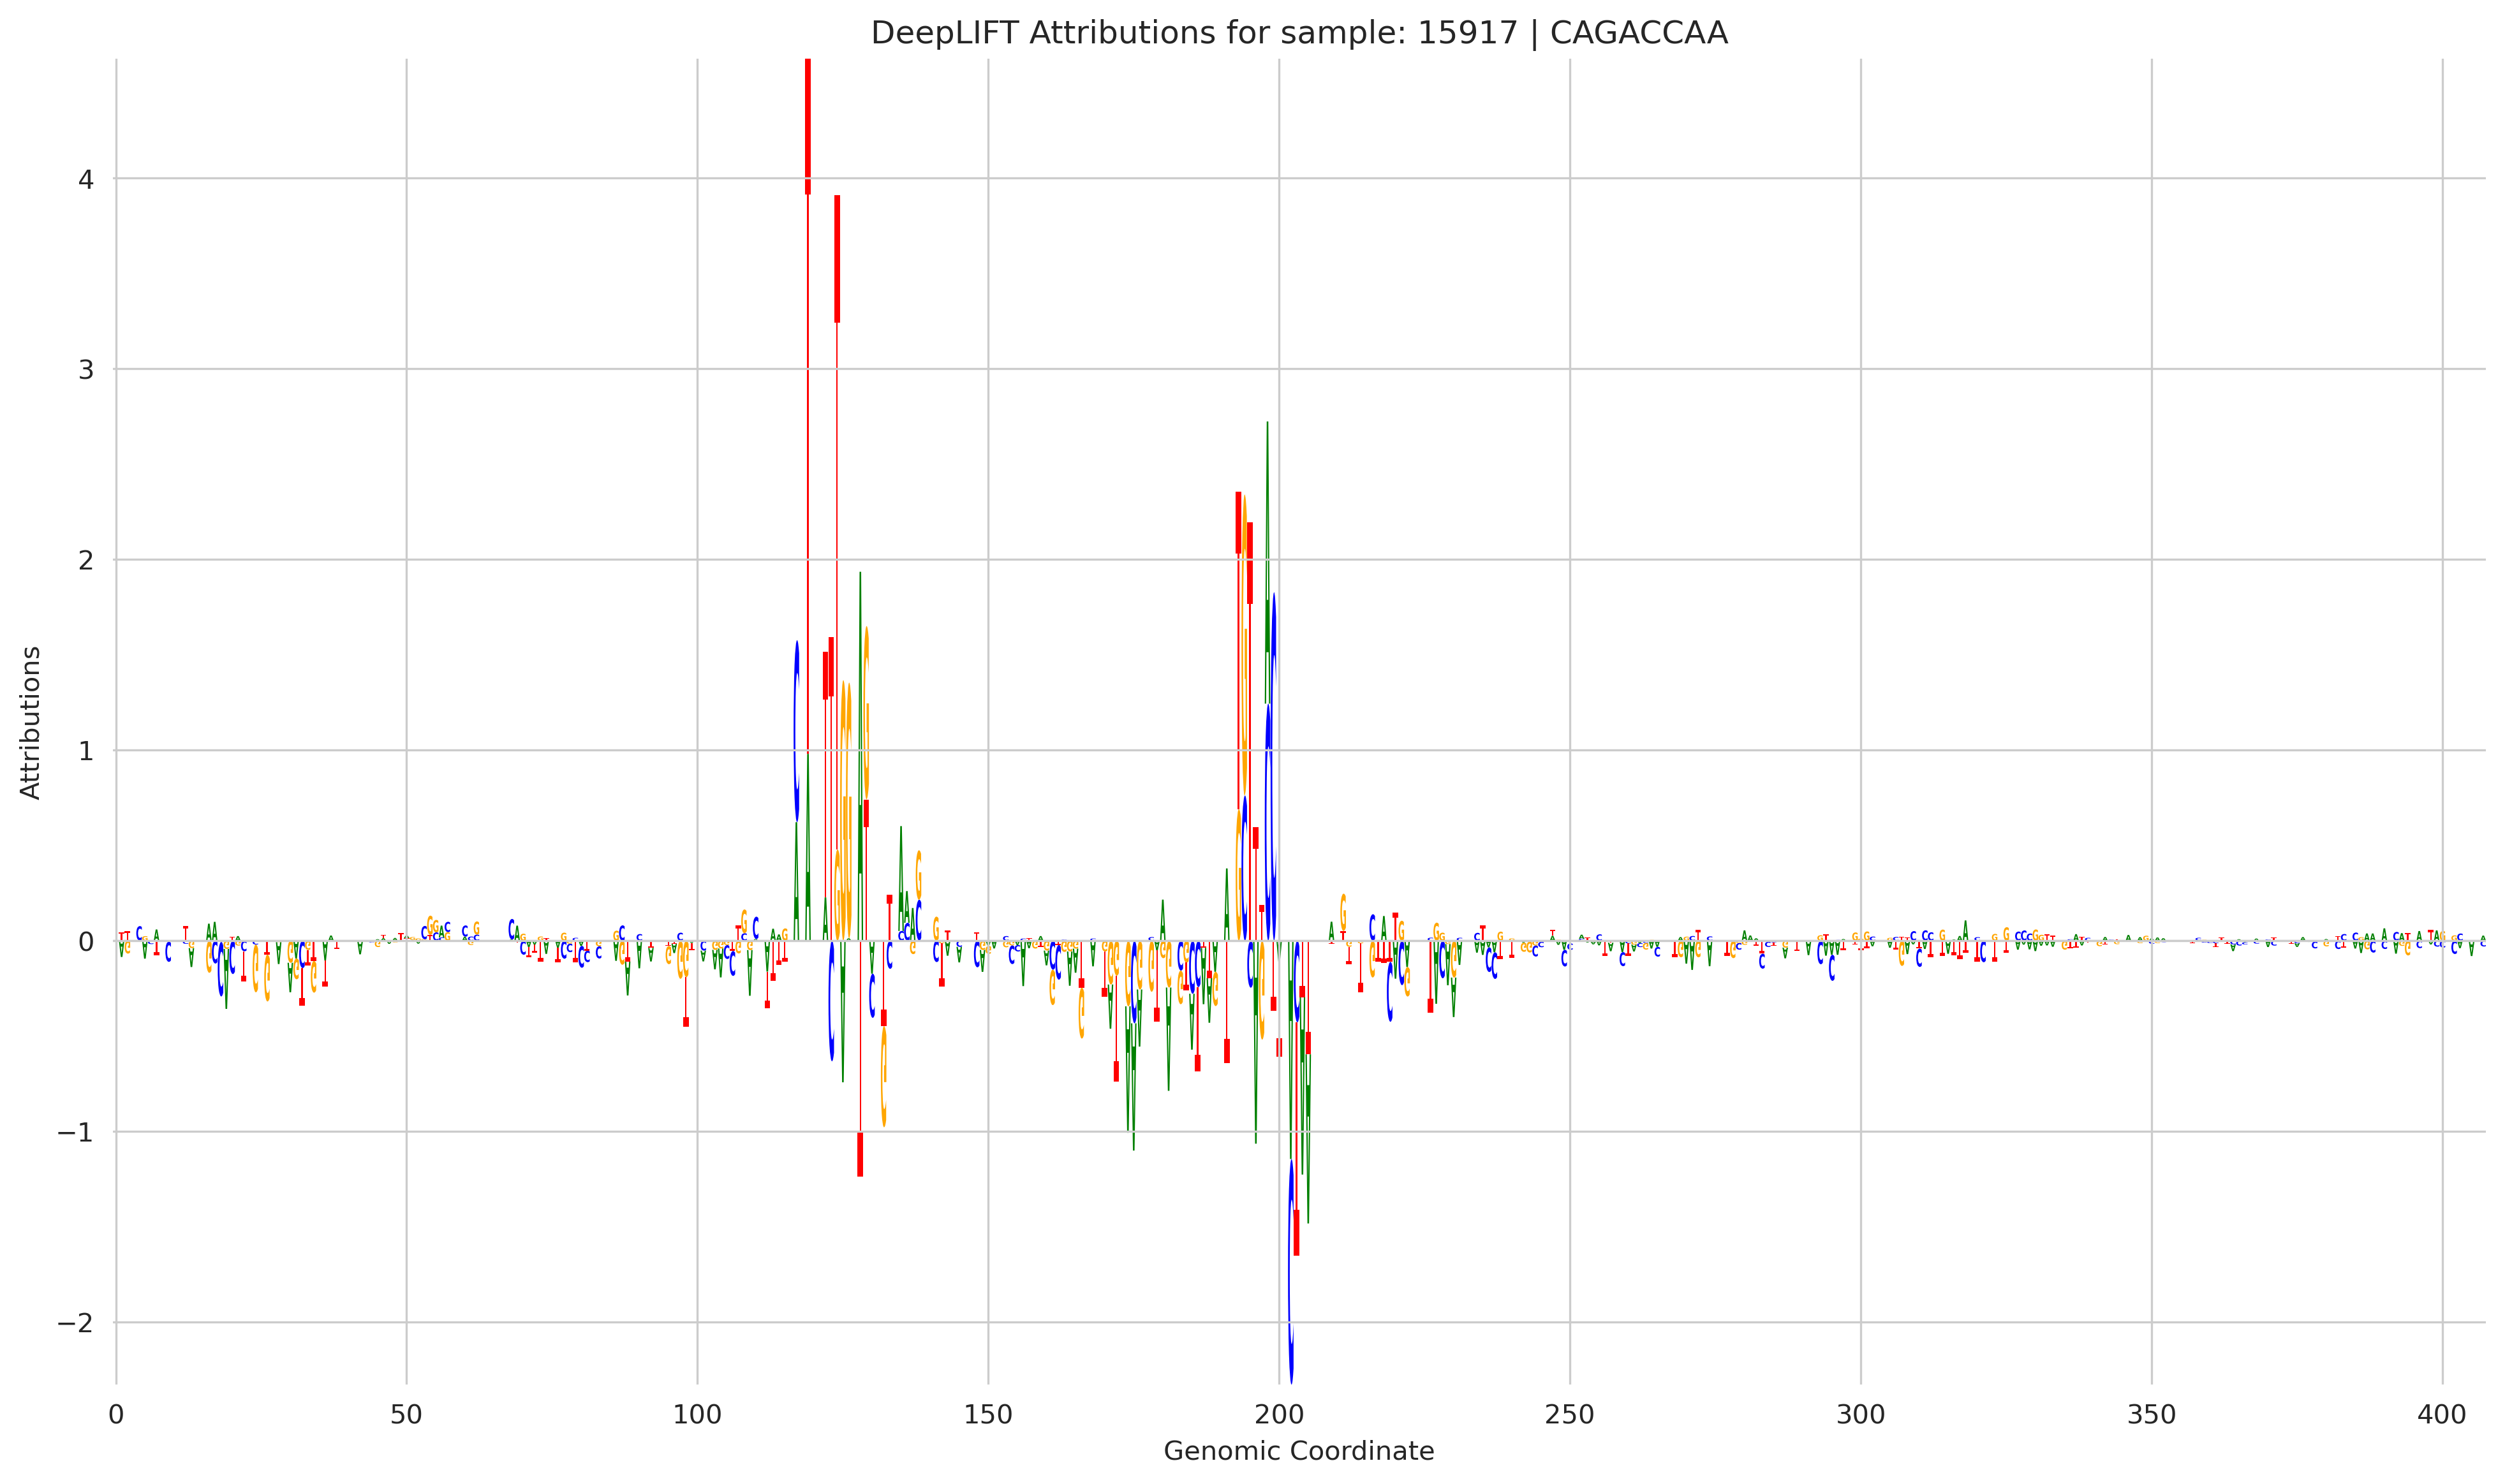

In [8]:
plot_seqlet(seqlets, attrs_list, sample_rank=1341, context_size=200)